In [70]:
!pip install supervision
!pip install ultralytics

In [71]:
import cv2 as cv
from cv2 import imshow

import numpy as np

from ultralytics import YOLO
from collections import defaultdict
import supervision as sv
import matplotlib.pyplot as plt

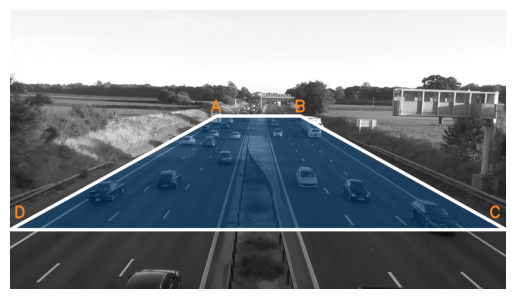

In [78]:
SOURCE_VIDEO = "/video1.mp4"
cap = cv.VideoCapture(SOURCE_VIDEO)
ret, img = cap.read()
cap.release()

img = cv.cvtColor(cv.cvtColor(img, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2BGR)



color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((800, 410), (1125, 410), (1920, 850), (0, 850)))

img = sv.draw_filled_polygon(img, poly, color1, 0.5)
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)
img = sv.draw_text(img, "A", sv.Point(800, 370), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1125, 370), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(1880, 780), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(40, 780), color2, 2, 6)


"""
color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")
poly = np.array(((0, 320), (1920, 320),  (1920, 1080),(0, 1080)))

img = sv.draw_filled_polygon(img, poly, color1, 0.5)
img = sv.draw_polygon(img, poly, sv.Color.WHITE, 12)
img = sv.draw_text(img, "A", sv.Point(40, 320), color2, 2, 6)
img = sv.draw_text(img, "B", sv.Point(1880, 320), color2, 2, 6)
img = sv.draw_text(img, "C", sv.Point(20, 1040), color2, 2, 6)
img = sv.draw_text(img, "D", sv.Point(1880, 1040), color2, 2, 6)
"""


plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis("off")  # Eksenleri kapatmak için
plt.show()



In [73]:
class Cam2WorldMapper:
    """Maps points from image to world coordinates using perspective transform."""

    def __init__(self) -> None:
        self.M: NDArray | None = None

    def __call__(self, image_pts):
        return self.map(image_pts)

    def find_perspective_transform(self, image_pts, world_pts):
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        world_pts = np.asarray(world_pts, dtype=np.float32).reshape(-1, 1, 2)
        self.M = cv.getPerspectiveTransform(image_pts, world_pts)
        return self.M

    def map(self, image_pts):
        if self.M is None:
            raise ValueError("Perspective transform not estimated")
        image_pts = np.asarray(image_pts, dtype=np.float32).reshape(-1, 1, 2)
        return cv.perspectiveTransform(image_pts, self.M).reshape(-1, 2)

In [74]:
# A, B, C, D previously found in the image.
image_pts = [(800, 410), (1125, 410), (1920, 850), (0, 850)]
# M6 is roughly 32 meters wide and 140 meters long there.
world_pts = [(0, 0), (32, 0), (32, 140), (0, 140)]

mapper = Cam2WorldMapper()
mapper.find_perspective_transform(image_pts, world_pts)
print(mapper.M)

[[  -0.027557   -0.050103      42.587]
 [-2.9606e-17    -0.52608      215.69]
 [         -0  -0.0031216           1]]


In [75]:
MPS_TO_KPH = 3.6


class Speedometer:
    """Estimates speed of objects in the world coordinates."""

    def __init__(self, mapper, fps, unit= MPS_TO_KPH):
        self._mapper = mapper
        self._fps = fps
        self._unit = unit
        self._speeds: defaultdict[int, list[int]] = defaultdict(list)

    @property
    def speeds(self):
        return self._speeds

    def update_with_trace(self, idx, image_trace):
        if len(image_trace) > 1:
            world_trace = self._mapper(image_trace)
            # Median displacement in x and y directions.
            # This stabilises after around several frames.
            dx, dy = np.median(np.abs(np.diff(world_trace, axis=0)), axis=0)
            ds = np.linalg.norm((dx, dy))
            self._speeds[idx].append(int(ds * self._fps * self._unit))

    def get_current_speed(self, idx):
        return self._speeds[idx][-1] if self._speeds[idx] else 0

In [76]:
# Custom color palette for object tracking.
colors = ("#007fff", "#0072e6", "#0066cc", "#0059b3", "#004c99", "#004080", "#003366", "#00264d")
color_palette = sv.ColorPalette(list(map(sv.Color.from_hex, colors)))

# The supervision VideoInfo provides some metadata about the video.
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
FPS = video_info.fps

# Polygonal zone that masks out detected objects that are outside it.
poly = np.array([(0, 410), (1920, 410), (1920, 900), (0, 900)])
zone = sv.PolygonZone(poly, (sv.Position.TOP_CENTER, sv.Position.BOTTOM_CENTER))

bbox_annotator = sv.BoxAnnotator(
    color=color_palette,
    thickness=2,
    color_lookup=sv.ColorLookup.TRACK,
)
trace_annotator = sv.TraceAnnotator(
    color=color_palette,
    position=sv.Position.CENTER,
    thickness=2,
    trace_length=FPS,
    color_lookup=sv.ColorLookup.TRACK,
)
label_annotator = sv.RichLabelAnnotator(
    color=color_palette,
    border_radius=2,
    font_size=16,
    color_lookup=sv.ColorLookup.TRACK,
    text_padding=6,
)

In [77]:
yolo = YOLO("yolo11m.pt", task="detect")
speedometer = Speedometer(mapper, FPS)

output_video = "/video1_cars_with_speed.mp4"
width, height = video_info.resolution_wh  # Inferenced image size
# YOLO expects the image size to be a multiple of 32
width, height = round(width / 32) * 32, round(height / 32) * 32
classes = [2, 5, 7]  # Car, Bus, Truck
conf = 0.4  # Detetion confidence threshold

with sv.VideoSink(output_video, video_info) as sink:
    for frame in sv.get_video_frames_generator(SOURCE_VIDEO):
        result = yolo.track(
            frame,
            classes=classes,
            conf=conf,
            imgsz=(height, width),
            persist=True,
            verbose=False,
            tracker="bytetrack.yaml",
        )
        detection = sv.Detections.from_ultralytics(result[0])
        # Mask out detections outside the zone.
        detection = detection[zone.trigger(detections=detection)]

        trace_ids = detection.tracker_id  # type: ignore
        speeds: list[int] = list()
        labels: list[str] = list()

        for trace_id in trace_ids:  # type: ignore
            image_trace = trace_annotator.trace.get(trace_id)
            speedometer.update_with_trace(int(trace_id), image_trace)
            current_speed = speedometer.get_current_speed(int(trace_id))
            speeds.append(current_speed)
            labels.append(f"#{trace_id} {current_speed} km/h")

        frame = cv.cvtColor(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), cv.COLOR_GRAY2RGB)
        frame = bbox_annotator.annotate(frame, detection)  # type: ignore
        frame = trace_annotator.annotate(frame, detection)  # type: ignore
        frame = label_annotator.annotate(frame, detection, labels=labels)  # type: ignore
        sink.write_frame(frame)